In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
import cdpm
from sklearn.preprocessing import add_dummy_feature, normalize
from tqdm import tqdm_notebook
from itertools import product

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')

In [3]:
alpha_for_ci = .95
num_draws = int(3000)
filename = '../results/star_simulation_estimates.tmp.hdf'
include_mean = True
time_dim = 2000

In [4]:
percentiles = [.1, 1,5, 25, 50, 75, 95, 99, 99.9]

In [5]:
simulated_data = cdpm.simulate_star(phi1 = 0.3, phi2 = -0.3, sigma = 0.5, scalep = 1, locp = 0, 
                                    time_dim=time_dim, df=10)

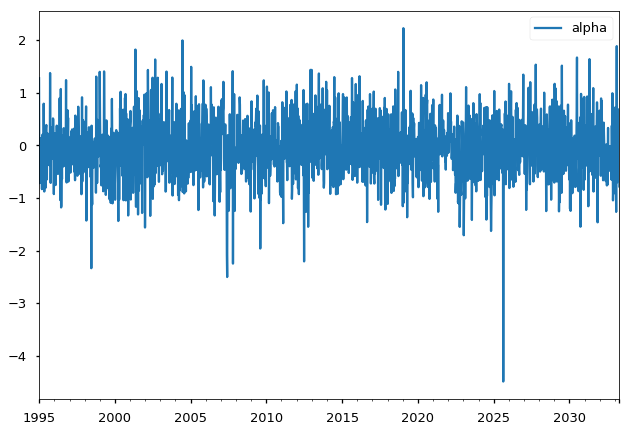

In [6]:
simulated_data.plot()

In [7]:
simulated_data.describe()

alpha
count  2000.000000
mean     -0.050028
std       0.561907
min      -4.490723
25%      -0.404615
50%      -0.044145
75%       0.289017
max       2.227260

In [8]:
alpha_series = simulated_data.alpha.values

## Estimation

In [9]:
if include_mean:
    regressor =  pd.DataFrame(add_dummy_feature(simulated_data.iloc[:-1]), index=simulated_data.index[:-1],
                             columns=['intercept'] + list(simulated_data.columns))
else:
    regressor = simulated_data.iloc[:-1]
    
regressand = simulated_data.iloc[1:]

In [10]:
regressand_dim = simulated_data.shape[1]
regressor_dim = regressand_dim + int(include_mean)
max_num_clusters = 100

In [11]:
stick_scale = 3
# mean and standard deviation
beta_mu,  = 0 * np.eye(regressand_dim,regressor_dim, k=-1)
beta_sigma = .1 * np.eye(regressor_dim, regressor_dim) 
comp_cov_nu = 3
comp_cov_mu = 3
comp_std_mean = .25
comp_cov_mean = comp_std_mean**2 * np.ones(regressand_dim)

In [12]:
prior = {
    'coeff': {'mean':list(beta_mu.ravel()), 'cov': list(beta_sigma.ravel()), 'hierarchical': True, 'nu': 5},
    'cov':  {'scale': list(comp_cov_mean), 'nu': comp_cov_nu, 'mu': comp_cov_mu, 'hierarchical': True},
    'expected_cluster_dim': stick_scale,
}

## Estimation

In [13]:
model = cdpm.CondDirichletProcessMix(regressor=regressor, regressand=regressand, prior=prior,              
                                             cluster_id=np.random.choice(5, size=regressor.shape[0]))     

In [16]:
return_dict = cdpm.estimate_cdpm(regressor=regressor,regressand=regressand, num_draws=num_draws, 
                                 progress_bar=tqdm_notebook, prior=prior,filename=filename,
                                 data=simulated_data, clusters=2)

In [17]:
cluster_identity_draws = return_dict['cluster_identity']
stick_draws = return_dict['sticks']
beta_draws = return_dict['beta']
comp_cov_draws = return_dict['comp_cov']
trans_mat_draws = return_dict['trans_mat']

## Simulation Results

In [18]:
prob = cdpm.compute_stationary_distribution([model.trans_mat]).T

In [19]:
stationary_dist = cdpm.compute_stationary_distribution(trans_mat_draws, progress_bar=tqdm_notebook)

In [20]:
stationary_dist.mean().cumsum().head(10)

0    0.009541
1    0.018752
2    0.026874
3    0.034163
4    0.040561
5    0.046584
6    0.053779
7    0.059927
8    0.067305
9    0.074712
dtype: float64

In [21]:
posterior_cluster_probs = pd.DataFrame(np.column_stack([np.mean(cluster_identity_draws == idx, axis=0) 
                           for idx in tqdm_notebook(np.unique(cluster_identity_draws))]),
                                       index=regressand.index)

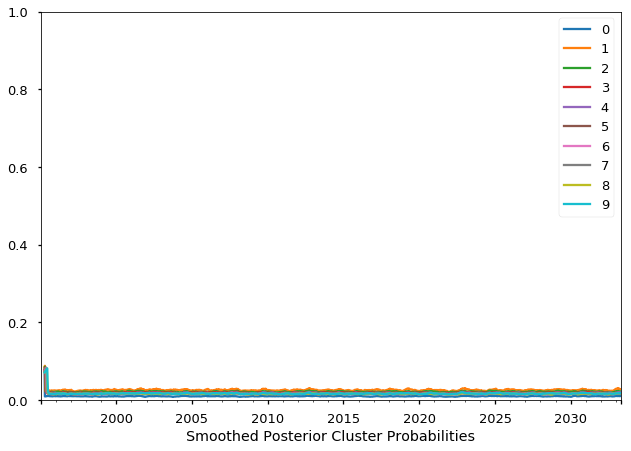

In [22]:
cluster_probs_fig, cluster_probs_ax = mpl.pyplot.subplots()
posterior_cluster_probs.rolling(15).mean().iloc[:,:10].plot(ax=cluster_probs_ax)
cluster_probs_ax.set_xlabel("Smoothed Posterior Cluster Probabilities")
cluster_probs_ax.set_ylim([0,1])
cluster_probs_fig.savefig('../doc/density_figures/smoothed_posterior_cluster_probs.tmp.pdf',
                          transparent=True, frameon=False, bbox_inches='tight', pad_inches=0)

In [23]:
percentiles

[0.1, 1, 5, 25, 50, 75, 95, 99, 99.9]

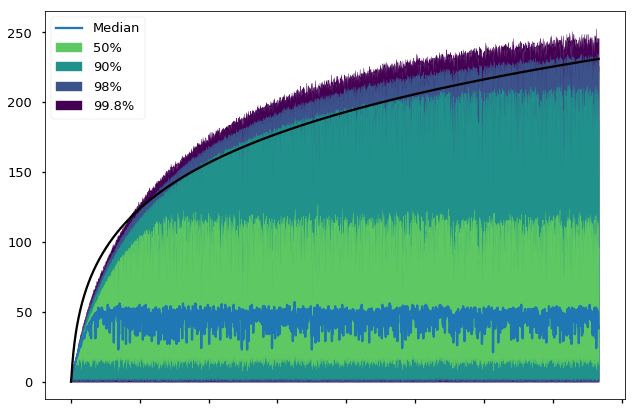

In [24]:
cluster_id_fig, cluster_id_ax = mpl.pyplot.subplots(1,1)
cdpm.fan_plot(ax=cluster_id_ax, data=pd.DataFrame(cluster_identity_draws.T, index=simulated_data.index[1:]),  
              percentiles=percentiles, labels=["Median", "99.8%", "98%", "90%", "50%"])
cluster_id_ax.plot(simulated_data.index[1:], 4 * np.log(np.arange(1, simulated_data.shape[0]))**2,
                   color='black', zorder=100)
cluster_id_ax.xaxis.set_ticklabels('')
cluster_id_filename = '../doc/density_figures/star_model_cluster_id.tmp.pdf'
cluster_id_ax.legend()
cluster_id_fig.savefig(cluster_id_filename, bbox_inches='tight', pad_inches=0,
                            transparent=True, fraemon=False)

In [25]:
alpha_est_mat = np.zeros((time_dim-1, num_draws // 10))
prod_iterator = tqdm_notebook(product(reversed(range(alpha_est_mat.shape[1])), range(1, time_dim)), 
                              total=alpha_est_mat.shape[1]*time_dim)
for draw, t_idx in prod_iterator:
    cluster_identity = cluster_identity_draws.iloc[-int(draw),(t_idx-1)].astype(int)
    probs = normalize(np.reshape(np.nan_to_num(trans_mat_draws[-draw][cluster_identity,:], 0), 
                     (1,-1)), norm='l1').ravel()
    cl_idx = int(np.random.choice(a=len(probs), p=probs))
    alpha_f = (regressor.values[t_idx-1] @ beta_draws[-draw, cl_idx] 
                   + comp_cov_draws[-draw, cl_idx]**(.5) * np.random.normal(0,1, size=1))
    alpha_est_mat[t_idx-1, -draw] = np.asscalar(alpha_f)

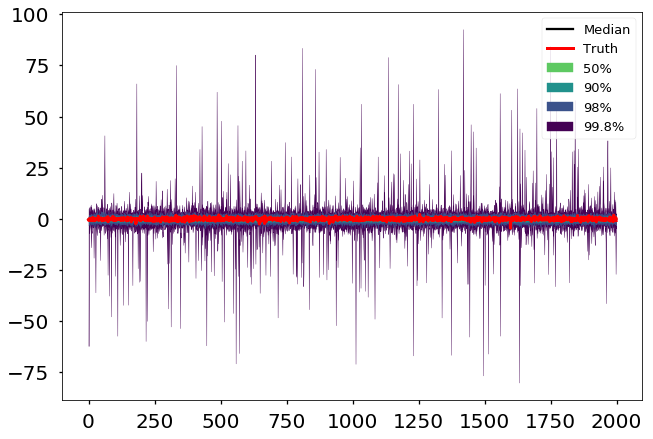

In [26]:
alpha_comparison_fig, alpha_comparison_ax = mpl.pyplot.subplots(1,1)
cdpm.fan_plot(ax=alpha_comparison_ax, data=pd.DataFrame(alpha_est_mat), percentiles=percentiles, color='black',
              labels=["Median", "99.8%", "98%", "90%", "50%"])
for label in alpha_comparison_ax.get_xticklabels():
    label.set_fontsize(20)
for label in alpha_comparison_ax.get_yticklabels():
    label.set_fontsize(20)
alpha_comparison_ax.plot(alpha_series[1:], c='red', label="Truth",  linewidth=3, zorder=100)
alpha_comparison_ax.legend()

alpha_comparison_filename = '../doc/density_figures/alpha_series_star.tmp.pdf'
alpha_comparison_fig.savefig(alpha_comparison_filename, bbox_inches='tight', pad_inches=0,
                            transparent=True, fraemon=False)


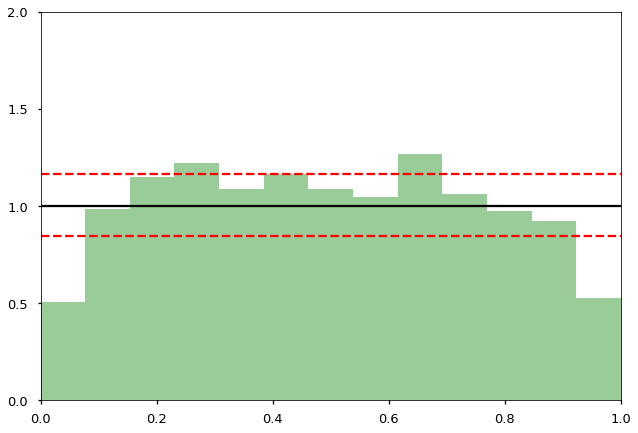

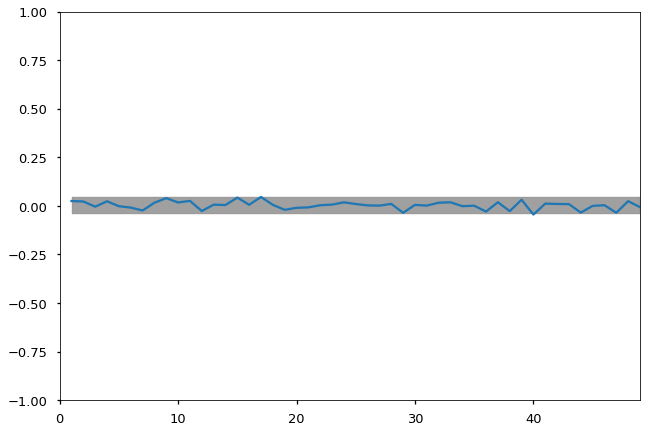

In [27]:
estimates = pd.DataFrame(alpha_est_mat, index=simulated_data.index[1:])
pit = cdpm.probability_integral_transform(estimates, simulated_data.iloc[1:])
pit_fig, pit_ax = mpl.pyplot.subplots()
cdpm.pit_plot(pit, ax=pit_ax, pct=.95, color='green')
# pit_ax.set_xlabel('Star Model')
pit_fig.savefig('../doc/density_figures/star_model_pit.tmp.pdf', bbox_inches='tight', pad_inches=0,
                transparent=True, frameon=False)
    
acf_fig, acf_ax = mpl.pyplot.subplots()
# acf_ax.set_xlabel('Star Model')
cdpm.pit_acf_plot(pit, ax=acf_ax, color='grey', alpha=.75)
acf_fig.savefig('../doc/density_figures/star_model_pit_acf.tmp.pdf', bbox_inches='tight', pad_inches=0,
                transparent=True, frameon=False)